# Project Name

## Report

## Code

In [180]:
# import libraries
import numpy
import sklearn
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# import Data
barts_hotspots = pd.read_csv('Dataset/barts_hotspots.csv')
barts_to_all = pd.read_csv('Dataset/barts_to_all.csv')
hotspots_to_all = pd.read_csv('Dataset/hotspots_to_all.csv')
hours_q1 = pd.read_csv('Dataset/hours_q1.csv')
hours_q2 = pd.read_csv('Dataset/hours_q2.csv')

### Data cleanning and understanding

In [6]:
# ger the list of barts and hotspots
barts_lst = barts_to_all["Origin Movement ID"].unique()
hotspots_lst = hotspots_to_all["Origin Movement ID"].unique()
display(barts_lst, hotspots_lst)

array([3603, 3692, 3760], dtype=int64)

array([3394, 3792, 3396], dtype=int64)

In [221]:
# the names of barts and hotspots
tb_hot_bart = pd.Series(barts_hotspots.groupby('Origin Movement ID')["Origin Display Name"].unique()).apply(lambda x: x[0]).to_frame()
display(tb_hot_bart)

,Origin Display Name
Origin Movement ID,
3394,"Fisherman's Wharf, San Francisco, CA"
3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra..."
3603,"Embarcadero, San Francisco, CA"
3692,2nd Street and Stevenson Street (Montgomery BA...
3760,"Powell BART Station, Market St and Powell St, ..."
3792,"Oracle Park, 24 Willie Mays Plaza, San Francis..."


In [16]:
# add a day of the week column to bars_hotspots table
barts_hotspots["Day of the Week"] = pd.to_datetime(barts_hotspots["Date"]).dt.day_name()

#### Null values

In [14]:
barts_hotspots.isnull().sum()

Date                                                          0
Origin Movement ID                                            0
Origin Display Name                                           0
Destination Movement ID                                       0
Destination Display Name                                      0
Daily Mean Travel Time (Seconds)                             58
Daily Range - Lower Bound Travel Time (Seconds)              58
Daily Range - Upper Bound Travel Time (Seconds)              58
AM Mean Travel Time (Seconds)                              1466
AM Range - Lower Bound Travel Time (Seconds)               1466
AM Range - Upper Bound Travel Time (Seconds)               1466
PM Mean Travel Time (Seconds)                               928
PM Range - Lower Bound Travel Time (Seconds)                928
PM Range - Upper Bound Travel Time (Seconds)                928
Midday Mean Travel Time (Seconds)                           727
Midday Range - Lower Bound Travel Time (

There are a lot of null values!!! Look closely, we know that for each time period, we have the same number of null values in lower bond, upper bond, and mean travel time. We made a resonable assumation that those rows are the same. 

Also, don't worry, for part 1, we do not need to assess every null value. For now, we will just deal with null values in "Daily Mean Travel Time (Seconds)", "AM Mean Travel Time (Seconds)", and "PM Mean Travel Time (Seconds)", which we will use in our first part in our project. Also, we will focusing on rows that the destination is one of the three hotspots

In [60]:
# get the table that the destination is one of three hotspots, and rename it to better manipulate
dest_tb = barts_hotspots.loc[barts_hotspots['Destination Movement ID'].apply(lambda x: True if x in hotspots_lst else False)]
dest_tb = dest_tb.loc[:,["Date", "Origin Movement ID", "Destination Movement ID", "Daily Mean Travel Time (Seconds)", "AM Mean Travel Time (Seconds)", "PM Mean Travel Time (Seconds)", "Day of the Week"]]
dest_tb = (
        dest_tb.rename(columns = {
            "Origin Movement ID": "Origin",
            "Destination Movement ID": "Dest",
            "Daily Mean Travel Time (Seconds)": "Daily",
            "AM Mean Travel Time (Seconds)": "AM",
            "PM Mean Travel Time (Seconds)": "PM",
            "Day of the Week": "Day"
        }).reset_index(drop=True)
)
display(dest_tb.head())
display(dest_tb.isnull().sum())

,Date,Origin,Dest,Daily,AM,PM,Day
0,04/28/2019,3603,3394,639.0,NaN,664.0,Sunday
1,05/18/2019,3603,3394,730.0,NaN,732.0,Saturday
2,04/23/2019,3603,3394,682.0,NaN,759.0,Tuesday
3,05/13/2019,3603,3394,634.0,NaN,650.0,Monday
4,04/14/2019,3603,3396,996.0,NaN,NaN,Sunday


Date        0
Origin      0
Dest        0
Daily      44
AM        842
PM        448
Day         0
dtype: int64

Much less!!! Good Job

In [62]:
# Take a closer look
null_tb = dest_tb.isnull().assign(**{'Day': dest_tb["Day"]})
null_tb.groupby('Day').mean()

,Date,Origin,Dest,Daily,AM,PM
Day,,,,,,
Friday,0.0,0.0,0.0,0.017094,0.452991,0.200855
Monday,0.0,0.0,0.0,0.035556,0.555556,0.213333
Saturday,0.0,0.0,0.0,0.034188,0.508547,0.405983
Sunday,0.0,0.0,0.0,0.038462,0.589744,0.444444
Thursday,0.0,0.0,0.0,0.008547,0.482906,0.217949
Tuesday,0.0,0.0,0.0,0.038462,0.534188,0.192308
Wednesday,0.0,0.0,0.0,0.017094,0.495726,0.247863


What we know?

1. Sunday and Saturday clearly have more null values in
2. AM clear has more null values than PM
3. We have a really small number of null values in Daily  

So how do we gonna to do with null values?

A: use the average number groupby day of the week, source, destination to replace the null values in PM and AM

In [85]:
# get the dictionary for values replacing null values
dict_null = dest_tb.groupby(['Day', 'Origin', "Dest"]).mean().to_dict()

In [90]:
dest_tb.head()

,Date,Origin,Dest,Daily,AM,PM,Day
0,04/28/2019,3603,3394,639.0,NaN,664.0,Sunday
1,05/18/2019,3603,3394,730.0,NaN,732.0,Saturday
2,04/23/2019,3603,3394,682.0,NaN,759.0,Tuesday
3,05/13/2019,3603,3394,634.0,NaN,650.0,Monday
4,04/14/2019,3603,3396,996.0,NaN,NaN,Sunday


In [117]:
def cleaner(row):
    lst = ["Daily", "AM", "PM"]
    day = row['Day']
    origin = row['Origin']
    dest = row['Dest']
    answer = [day, origin, dest]
    for col in lst:
        if np.isnan(row[col]):
            if dict_null[col][day, origin, dest] != np.nan:
                answer.append(dict_null[col][day, origin, dest])
        else:
            answer.append(row[col])
    ind = ['Day', 'Origin', "Dest", "Daily", "AM", "PM"]
    return pd.Series(answer, index=ind)

In [118]:
clean = dest_tb.apply(cleaner, axis=1)

In [119]:
clean.isnull().sum()

Day         0
Origin      0
Dest        0
Daily       0
AM        309
PM        130
dtype: int64

Much less null values!!!
Notice that there are still some null values because for some specific combination of origin, destination, and the day of the week, there is not even a one value. However, this will not be a problem for us since if there is not even a one value, it means that nobody takes that ride in that spefic day from that spefici origin to that spefic destination. As a result, it means it is a bad choice (crowd wisdom!!). We will explain more in the report part.

Also, we will use the clean table in following whole part 1

In [135]:
# solve p1q1p1
fisher = clean.loc[clean['Dest'] == 3394] # get the table with the destination of 3394
display(fisher.groupby('Origin')['AM', 'PM'].mean()) # through the day
display(fisher.groupby(['Day', 'Origin'])['Daily'].mean().to_frame()) # through the week

,AM,PM
Origin,,
3603,624.187451,727.192563
3692,810.809063,912.457459
3760,829.887428,1006.778158


Daily
Day       Origin            
Friday    3603    674.615385
          3692    833.923077
          3760    928.346154
Monday    3603    655.200000
          3692    755.760000
          3760    861.160000
Saturday  3603    681.961538
          3692    789.846154
          3760    914.038462
Sunday    3603    656.346154
          3692    727.730769
          3760    860.307692
Thursday  3603    674.538462
          3692    829.692308
          3760    900.000000
Tuesday   3603    651.423077
          3692    778.615385
          3760    888.346154
Wednesday 3603    661.076923
          3692    802.730769
          3760    902.576923

1. With the destination of 3394, if we consider the time of the day (am or pm), we should choose BART 3603 for both am and pm
2. Withe the destination of 3394, if we consider the day of the week, we should choose BART 3603 for all days
3. The reason behind is that 3603 is close enough that the time and the day factor could not even affect our decision

In [136]:
# solve p1q1p1
palace = clean.loc[clean['Dest'] == 3396] # get the table with the destination of 3396
display(palace.groupby('Origin')['AM', 'PM'].mean()) # through the day
display(palace.groupby(['Day', 'Origin'])['Daily'].mean().to_frame()) # through the week

,AM,PM
Origin,,
3603,1108.083333,1345.408668
3692,1241.040000,1430.269016
3760,1476.000000,1558.883495


Daily
Day       Origin             
Friday    3603    1202.576923
          3692    1337.961538
          3760    1305.681818
Monday    3603    1174.560000
          3692    1284.240000
          3760    1351.235294
Saturday  3603    1181.000000
          3692    1259.269231
          3760    1293.526316
Sunday    3603    1164.681818
          3692    1209.360000
          3760    1220.681818
Thursday  3603    1178.615385
          3692    1314.230769
          3760    1318.708333
Tuesday   3603    1201.961538
          3692    1293.884615
          3760    1281.352941
Wednesday 3603    1210.153846
          3692    1296.269231
          3760    1309.363636

1. With the destination of 3396, if we consider the time of the day (am or pm), we should choose BART 3603 for both am and pm
2. Withe the destination of 3396, if we consider the day of the week, we should choose BART 3603 for all days
3. The reason behind is that 3603 is close enough that the time and the day factor could not even affect our decision

In [137]:
# solve p1q1p1
park = clean.loc[clean['Dest'] == 3792] # get the table with the destination of 3396
display(park.groupby('Origin')['AM', 'PM'].mean()) # through the day
display(park.groupby(['Day', 'Origin'])['Daily'].mean().to_frame()) # through the week

,AM,PM
Origin,,
3603,547.150015,771.707182
3692,455.616483,597.204420
3760,795.395880,907.986552


Daily
Day       Origin            
Friday    3603    613.730769
          3692    506.653846
          3760    780.615385
Monday    3603    579.800000
          3692    482.920000
          3760    748.840000
Saturday  3603    509.769231
          3692    385.076923
          3760    807.423077
Sunday    3603    518.346154
          3692    416.076923
          3760    757.961538
Thursday  3603    630.307692
          3692    546.692308
          3760    774.730769
Tuesday   3603    596.538462
          3692    506.923077
          3760    762.961538
Wednesday 3603    605.653846
          3692    529.576923
          3760    796.807692

1. With the destination of 3792, if we consider the time of the day (am or pm), we should choose BART 3692 for both am and pm
2. Withe the destination of 3792, if we consider the day of the week, we should choose BART 3692 for all days
3. The reason behind is that 3692 is close enough that the time and the day factor could not even affect our decision

Part 1 Problem 2:
We decide to choose the financial district as our "center". Any trip that is leaving from financial district is counted as "Leaving" and any trip that is going toward "financial district" is countes as "Heading". The trip which accrose the center will be labeled as "Cross".

![barts and hotspots](Dataset/map.jpg)

Now, lets label each trips in table barts_hotspots.
According to the map, we will label each BART station and each hotspot a coordinate (x, y) in order to represent the geological relations. Given financial disrict as (0,0), we dicide to label:

1. 3603: (1, 1)
2. 3692: (-1, -1)
3. 3760: (-2, -1)
4. 3792: (2, -2)
5. 3394: (-3, 3)
6. 3396: (-4, 2)

Since we only care the sign of each coordinates' difference, the value of each x and y are simply represented the rank of that direction. For example, 3396 is third right to the center and second above to the center so we give it (-3,2)

In [149]:
# since now the purpose is to compare each trip, in order to save time, we do not deal with null values
dct_xy = {3603: (1, 1), 3692: (1, -1), 3760: (-1, -1), 3792: (1, -2), 3394: (-2, 3), 3396: (-3, 2)}
# the function to generate the direction for each trip
def direction_judge(start, end):
    start = dct_xy[start]
    end = dct_xy[end]
    j1 = start[0] * end[0]
    j2 = start[1] * end[1]
    d1 = start[0]**2 + start[1]**2
    d2 = end[0]**2 + end[1]**2
    if j1 < 0 and j2 < 0:
        return "Cross"
    if d1 < d2:
        return "Leaving"
    if d1 >= d2:
        return "Towarding"
compare = barts_hotspots.assign(**{'coordinate': barts_hotspots.apply(lambda x: direction_judge(x["Origin Movement ID"], x['Destination Movement ID']), axis=1)})

In [246]:
compare.head()

,Date,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Daily Mean Travel Time (Seconds),Daily Range - Lower Bound Travel Time (Seconds),Daily Range - Upper Bound Travel Time (Seconds),AM Mean Travel Time (Seconds),AM Range - Lower Bound Travel Time (Seconds),...,Midday Range - Lower Bound Travel Time (Seconds),Midday Range - Upper Bound Travel Time (Seconds),Evening Mean Travel Time (Seconds),Evening Range - Lower Bound Travel Time (Seconds),Evening Range - Upper Bound Travel Time (Seconds),Early Morning Mean Travel Time (Seconds),Early Morning Range - Lower Bound Travel Time (Seconds),Early Morning Range - Upper Bound Travel Time (Seconds),Day of the Week,coordinate
0,06/09/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3603,"Embarcadero, San Francisco, CA",1588.0,1054.0,2392.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday,Towarding
1,04/28/2019,3603,"Embarcadero, San Francisco, CA",3394,"Fisherman's Wharf, San Francisco, CA",639.0,512.0,796.0,NaN,NaN,...,524.0,817.0,608.0,492.0,753.0,NaN,NaN,NaN,Sunday,Leaving
2,05/18/2019,3603,"Embarcadero, San Francisco, CA",3394,"Fisherman's Wharf, San Francisco, CA",730.0,520.0,1024.0,NaN,NaN,...,590.0,1061.0,569.0,406.0,797.0,NaN,NaN,NaN,Saturday,Leaving
3,04/18/2019,3792,"Oracle Park, 24 Willie Mays Plaza, San Francis...",3603,"Embarcadero, San Francisco, CA",512.0,371.0,705.0,648.0,461.0,...,398.0,702.0,442.0,321.0,608.0,363.0,297.0,443.0,Thursday,Towarding
4,04/08/2019,3792,"Oracle Park, 24 Willie Mays Plaza, San Francis...",3603,"Embarcadero, San Francisco, CA",505.0,364.0,701.0,621.0,489.0,...,339.0,542.0,502.0,354.0,711.0,NaN,NaN,NaN,Monday,Towarding


In [248]:
# compare and contrast based on day of the week
# replace the words of day of the week to numbers 1-7
dct_day = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
compare_day = compare.assign(**{"Day of the Week": compare["Day of the Week"].apply(lambda x: dct_day[x])})
compare_day = compare_day.groupby(["Origin Movement ID", "Destination Movement ID", "Day of the Week"])['Daily Mean Travel Time (Seconds)'].mean().to_frame()
compare_day

Daily Mean Travel Time (Seconds)
Origin Movement ID Destination Movement ID Day of the Week                                  
3394               3603                    1                                      750.720000
                                           2                                      799.153846
                                           3                                      770.153846
                                           4                                      833.730769
                                           5                                      797.769231
                                           6                                      783.846154
                                           7                                      720.307692
                   3692                    1                                     1010.760000
                                           2                                     1056.192308
                                           3                                     1027.230769
                                           4                                     1092.807692
                                           5                                     1062.230769
                                           6                                      977.115385
                                           7                                      877.423077
                   3760                    1                                      975.360000
                                           2                                     1026.576923
                                           3                                     1011.653846
                                           4                                     1047.961538
                                           5                                     1092.961538
                                           6                                     1076.153846
                                           7                                      982.884615
3396               3603                    1                                     1297.041667
                                           2                                     1296.230769
                                           3                                     1311.692308
                                           4                                     1336.846154
                                           5                                     1286.615385
                                           6                                     1303.000000
                                           7                                     1260.650000
                   3692                    1                                     1461.640000
                                           2                                     1514.384615
...                                                                                      ...
3760               3396                    6                                     1293.526316
                                           7                                     1220.681818
                   3792                    1                                      748.840000
                                           2                                      762.961538
                                           3                                      796.807692
                                           4                                      774.730769
                                           5                                      780.615385
                                           6                                      807.423077
                                           7                                      757.961538
3792               3603                    1                                      531.000000
                                           2                 

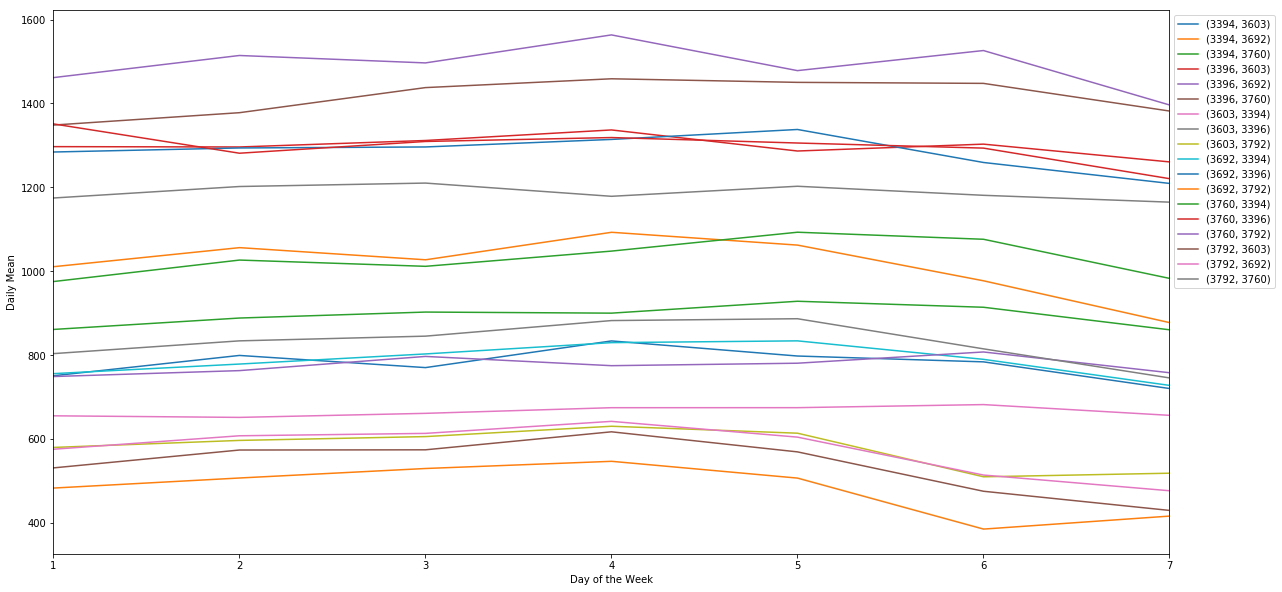

In [250]:
# let's plot it~

# plot the data
tb_day_plot = compare_day.pivot_table(columns = ("Origin Movement ID", "Destination Movement ID"), index = "Day of the Week", values="Daily Mean Travel Time (Seconds)")
ax = tb_day_plot.plot(figsize=(20,10))
ax.set_ylabel('Daily Mean')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

We can see that:

1. In general, the difference between each combination of origin and destination (distance of the trip) will have a much bigger effect than the the day of the week
2. In general, there will be a minimum for each line on Sunday

In [251]:
# compare and contrast based on the direction and the day of the week
compare_day_dir = compare.assign(**{"Day of the Week": compare["Day of the Week"].apply(lambda x: dct_day[x])})
compare_day_dir = compare_day_dir.groupby(["coordinate", "Day of the Week"])['Daily Mean Travel Time (Seconds)'].mean().to_frame()
compare_day_dir

Daily Mean Travel Time (Seconds)
coordinate Day of the Week                                  
Cross      1                                     1128.100000
           2                                     1160.769231
           3                                     1155.730769
           4                                     1200.048077
           5                                     1178.105769
           6                                     1138.105769
           7                                     1047.843137
Leaving    1                                      811.574850
           2                                      818.468208
           3                                      849.202247
           4                                      855.422222
           5                                      848.848315
           6                                      803.775862
           7                                      781.109195
Towarding  1                                      895.068966
           2                                      928.254144
           3                                      937.692308
           4                                      974.098901
           5                                      955.417582
           6                                      911.333333
           7                                      837.352601

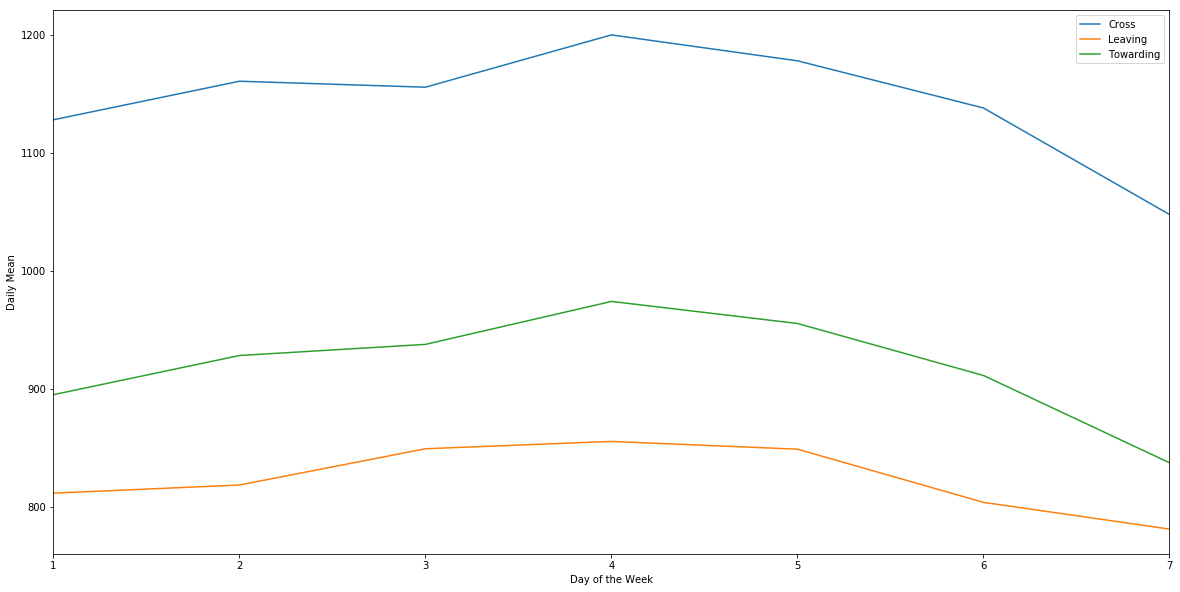

In [252]:
# plot the data
tb_day_plot = compare_day_dir.pivot_table(columns = "coordinate", index = "Day of the Week", values="Daily Mean Travel Time (Seconds)")
ax = tb_day_plot.plot(figsize=(20,10))
ax.set_ylabel('Daily Mean')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

We can see that:

1. Cross typical have the longest average travel time in general and leaving have the shortest. This is reasonable since cross trips ususally have a large distance and also leaving from downtown ususally takes less time than heading toward downtown.
2. Also, all lines will have a minimum on Sunday and a slightly peak on Thursday
3. The general trend is going up from monday to thursday and then decrease from friday to sunday

In [200]:
# compare and contrast based on the time of the day 
compare_time = compare.groupby(["Origin Movement ID", "Destination Movement ID"])["Midday Mean Travel Time (Seconds)", "Evening Mean Travel Time (Seconds)", "Early Morning Mean Travel Time (Seconds)"].mean()
compare_time

Midday Mean Travel Time (Seconds)  \
Origin Movement ID Destination Movement ID                                      
3394               3603                                            754.877095   
                   3692                                           1049.000000   
                   3760                                            999.672222   
3396               3603                                           1304.377358   
                   3692                                           1495.503937   
                   3760                                           1396.802632   
3603               3394                                            682.435754   
                   3396                                           1214.508197   
                   3792                                            606.734807   
3692               3394                                            804.513966   
                   3396                                           1313.676190   
                   3792                                            522.238889   
3760               3394                                            863.150000   
                   3396                                           1286.710526   
                   3792                                            799.848214   
3792               3603                                            520.222222   
                   3692                                            570.005556   
                   3760                                            828.360000   

                                            Evening Mean Travel Time (Seconds)  \
Origin Movement ID Destination Movement ID                                       
3394               3603                                             667.865497   
                   3692                                             870.788889   
                   3760                                             945.329609   
3396               3603                                            1188.700000   
                   3692                                            1363.133333   
                   3760                                            1351.777778   
3603               3394                                             581.982759   
                   3396                                            1045.547368   
                   3792                                             488.677778   
3692               3394                                             711.474860   
                   3396                                            1195.585859   
                   3792                                             425.688889   
3760               3394                                             849.376404   
                   3396                                            1245.000000   
                   3792                                             699.551402   
3792               3603                                             435.596591   
                   3692                                             481.744444   
                   3760                                             719.909091   

                                            Early Morning Mean Travel Time (Seconds)  
Origin Movement ID Destination Movement ID                                            
3394               3603                                                   697.307692  
                   3692                                                   705.333333  
                   3760                                                   831.833333  
3396               3603                                                          NaN  
                   3692                                                  1156.727273  
                   3760                                                  1685.000000  
3603               3394                                                   534.600000  

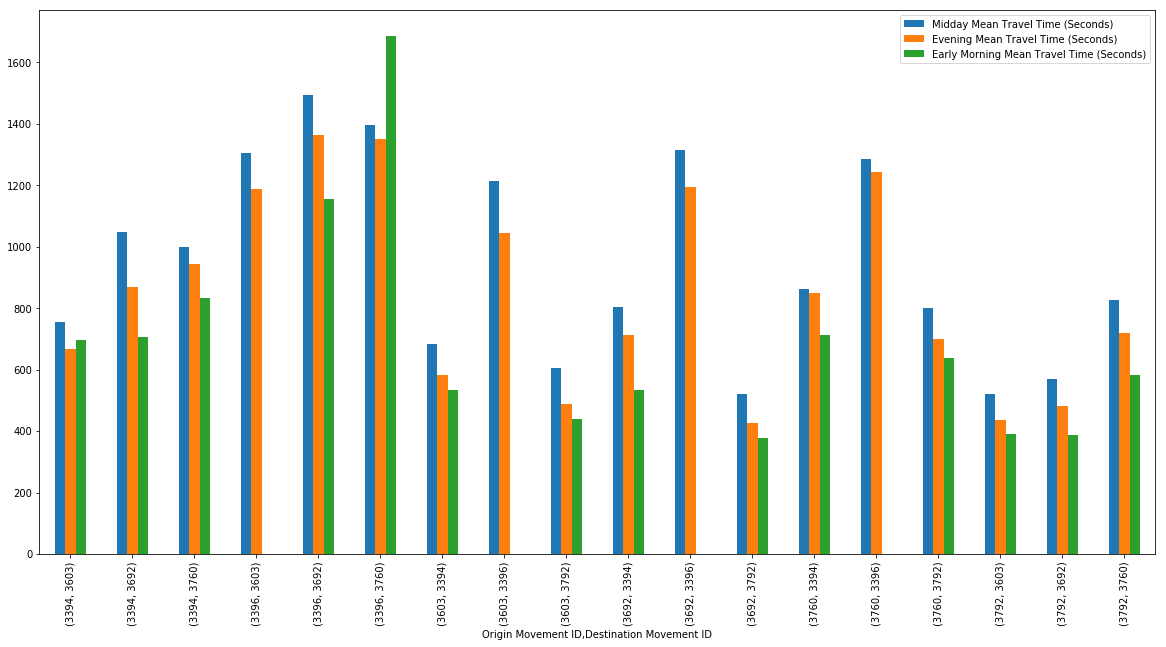

In [205]:
# plot the data
tb_day_plot = compare_time
ax = tb_day_plot.plot(kind = 'bar',figsize=(20,10))
ax.legend(bbox_to_anchor=(1,1))
plt.show()

What we can see:

1. In general, the travel time from long to short is : Midday > Evening > Early Morning. We do not know the spcific time period for each stage but we can reasonbal guess that in early morning, there are less cars on roads and thus have a shorter average travel time
2. There is a special case, (3396, 3760), which has the longes travel time in early morning, we will evaluate this special case later

In [208]:
# compare and contrast based on the time of the day 
compare_time_dir = compare.groupby("coordinate")["Midday Mean Travel Time (Seconds)", "Evening Mean Travel Time (Seconds)", "Early Morning Mean Travel Time (Seconds)"].mean()
compare_time_dir

,Midday Mean Travel Time (Seconds),Evening Mean Travel Time (Seconds),Early Morning Mean Travel Time (Seconds)
coordinate,,,
Cross,1117.923858,908.510246,642.406375
Leaving,774.186492,650.748913,425.694301
Towarding,811.635021,657.915049,441.633333


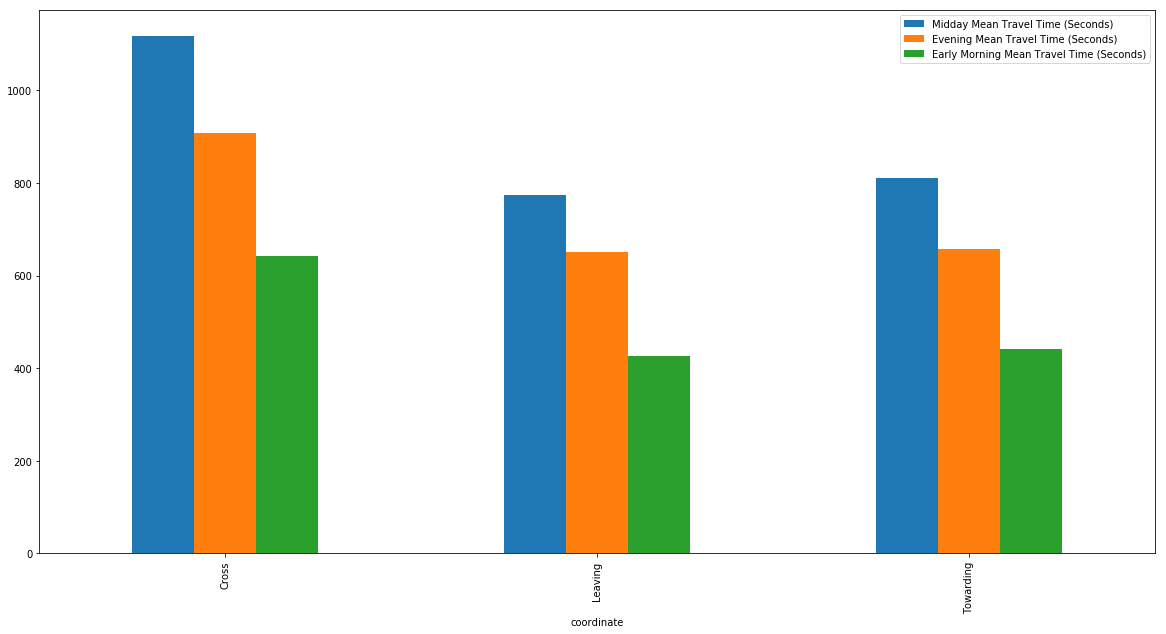

In [209]:
# plot the data
tb_day_plot = compare_time_dir
ax = tb_day_plot.plot(kind = 'bar',figsize=(20,10))
ax.legend(bbox_to_anchor=(1,1))
plt.show()

What we can see:

Basically the same with the one before

In [213]:
# compared based on the day of the week and the time of the day
compare_time_day = compare.groupby("Day of the Week")["Midday Mean Travel Time (Seconds)", "Evening Mean Travel Time (Seconds)", "Early Morning Mean Travel Time (Seconds)"].mean()
compare_time_day

,Midday Mean Travel Time (Seconds),Evening Mean Travel Time (Seconds),Early Morning Mean Travel Time (Seconds)
Day of the Week,,,
Friday,936.125000,740.563798,468.282443
Monday,808.046012,657.013378,463.725275
Saturday,908.417722,731.676375,485.589744
Sunday,850.984211,618.343396,514.968992
Thursday,895.337950,752.106936,474.737705
Tuesday,813.440476,712.368902,545.885496
Wednesday,849.538682,730.781609,492.753968


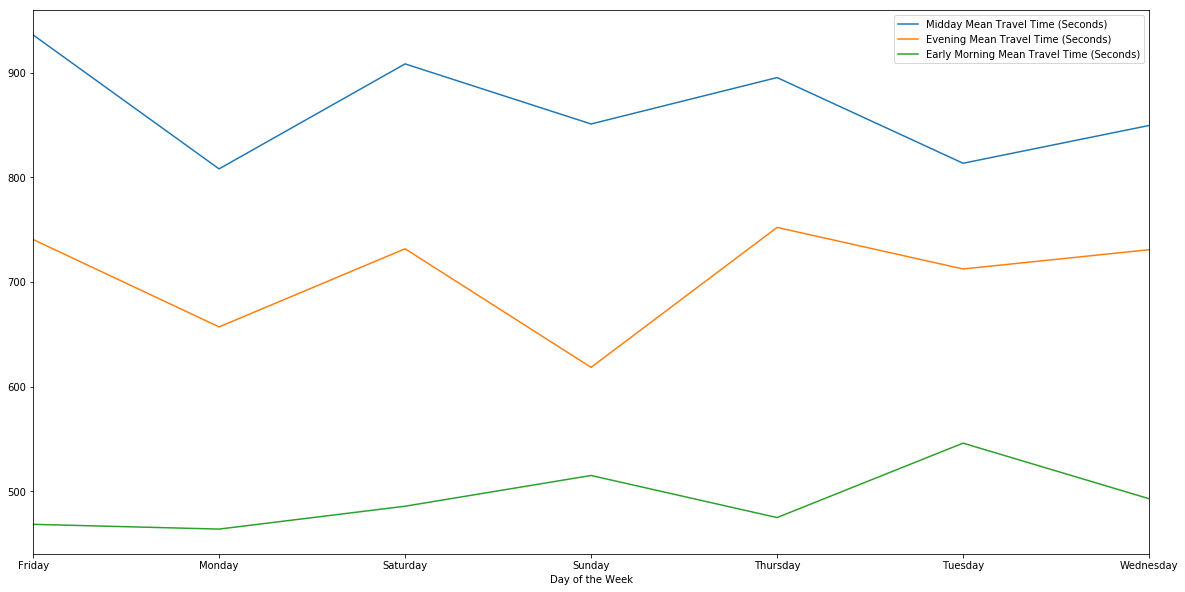

In [215]:
# plot the data
tb_day_plot = compare_time_day
ax = tb_day_plot.plot(figsize=(20,10))
ax.legend(bbox_to_anchor=(1,1))
plt.show()

What we see:
1. We have a new found! Usually travel time will be shorter on Sunday. However, the early morning mean travel time will slightly increase on Sunday.

In [231]:
# special case (3396, 3760)
# first, what are those two locations
temp_dct = tb_hot_bart.to_dict()["Origin Display Name"]
display(temp_dct[3396], temp_dct[3760])

'The Palace Of Fine Arts, 3601 Lyon St, San Francisco, CA'

'Powell BART Station, Market St and Powell St, San Francisco, CA'

go take a look at the google map! In order to show it is the early morning, we set the depature time to 6:00 am
![specialcase morning](Dataset/specialcase1.PNG)
set it to 12:00 pm
![noon](Dateset/specialcase2.PNG)

It is pretty odd. Why our data is not consistant with google map? Maybe it is time to take a closer look to the data set

In [239]:
special_case = barts_hotspots.loc[(barts_hotspots['Origin Movement ID'] == 3396) & (barts_hotspots['Destination Movement ID'] == 3760)]
special_case.head()

,Date,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Daily Mean Travel Time (Seconds),Daily Range - Lower Bound Travel Time (Seconds),Daily Range - Upper Bound Travel Time (Seconds),AM Mean Travel Time (Seconds),AM Range - Lower Bound Travel Time (Seconds),...,Midday Mean Travel Time (Seconds),Midday Range - Lower Bound Travel Time (Seconds),Midday Range - Upper Bound Travel Time (Seconds),Evening Mean Travel Time (Seconds),Evening Range - Lower Bound Travel Time (Seconds),Evening Range - Upper Bound Travel Time (Seconds),Early Morning Mean Travel Time (Seconds),Early Morning Range - Lower Bound Travel Time (Seconds),Early Morning Range - Upper Bound Travel Time (Seconds),Day of the Week
1097,05/31/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3760,"Powell BART Station, Market St and Powell St, ...",1470.0,1126.0,1917.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friday
1103,04/21/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3760,"Powell BART Station, Market St and Powell St, ...",1238.0,1052.0,1456.0,NaN,NaN,...,1156.0,1068.0,1251.0,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
1108,04/12/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3760,"Powell BART Station, Market St and Powell St, ...",1403.0,1183.0,1664.0,NaN,NaN,...,1440.0,1190.0,1742.0,NaN,NaN,NaN,NaN,NaN,NaN,Friday
1109,06/02/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3760,"Powell BART Station, Market St and Powell St, ...",1292.0,1055.0,1583.0,NaN,NaN,...,1177.0,1048.0,1322.0,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
1111,05/01/2019,3396,"The Palace Of Fine Arts, 3601 Lyon St, San Fra...",3760,"Powell BART Station, Market St and Powell St, ...",1272.0,1058.0,1529.0,NaN,NaN,...,1343.0,1081.0,1668.0,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday


### Part 2

#### What we know from part 1? What we are gonna do in part 2?

1. The major effect is the distance between two places. However, we do not have the distance data in this project. Thus we we will not include distance as a major factor to our time series model. 
2. Travel time between different combination of origin and destination do share a common pattern of variation through the week. We will extract and include this pattern in our model for forecasting
3. Observing the result of part 1, the time of the day also have a pattern. However, three division "Early Morning", "Evening", "Midday" is not enough for us. Thus, we dicide to analysis the tables, hours_q1, hours_q2, to find the pattern of the travel time variation between the time of the day.
4. We will first build a model to forecast the average travel time of whole trips (all combination of origin and destination). Then we will also build 6 specific models for 6 trips between spefic BARTs and hotspots.

The pattern of the day of the week
![daypattern](Dataset\compare_day.png)